In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [65]:
# parametri fisici oscillatore
m = 1.
omega = 1.
r = 0.001 #0.05

# parametri fisici bagno
#k_B = 1.38065156*10**(-23)
k_B = 1.
T = 50
beta = 1/(k_B*T)

In [3]:
# Definizione della distribuzione di Gibbs
def gibbs_distribution(q, p):
    return np.exp(-beta*((p**2)/(2*m) + (m*omega**2)*(q**2)/2))

def gibbs_distribution_nonlinear(q, p):
    return np.exp(-beta*((p**2)/(2*m) + (m*omega**2)*(q**2)/2 + r*(q**4)/4))

In [4]:
# Definizione della proposta di transizione (scelta semplice per dimostrazione)
def proposal(x, y):
    x_new = x + np.random.normal()
    y_new = y + np.random.normal()
    return x_new, y_new

In [5]:
# Parametri dell'algoritmo di campionamento
num_samples = 10000
burn_in = 1000

In [6]:
# Inizializzazione campionamento
current_q, current_p = 0.0, 0.0
samples = []

In [7]:
# Ciclo di campionamento delle q e delle p
for _ in range(num_samples + burn_in):
    proposed_q, proposed_p = proposal(current_q, current_p)
    
    acceptance_ratio = min(1, gibbs_distribution_nonlinear(proposed_q, proposed_p)/gibbs_distribution_nonlinear(current_q, current_p))
    
    if np.random.uniform() < acceptance_ratio:
        current_q, current_p = proposed_q, proposed_p
    
    if _ >= burn_in:
        samples.append((current_q, current_p))

In [8]:
# Estrazione dei campioni di x e y
sampled_q = [sample[0] for sample in samples]
sampled_p = [sample[1] for sample in samples]

sampled_q = np.array(sampled_q) 
sampled_p = np.array(sampled_p) 

In [9]:
np.mean(sampled_p*sampled_p/m)

55.01869922336863

In [10]:
np.mean((m*omega*omega)*sampled_q*sampled_q + r*sampled_q*sampled_q*sampled_q*sampled_q)

47.77691294673747

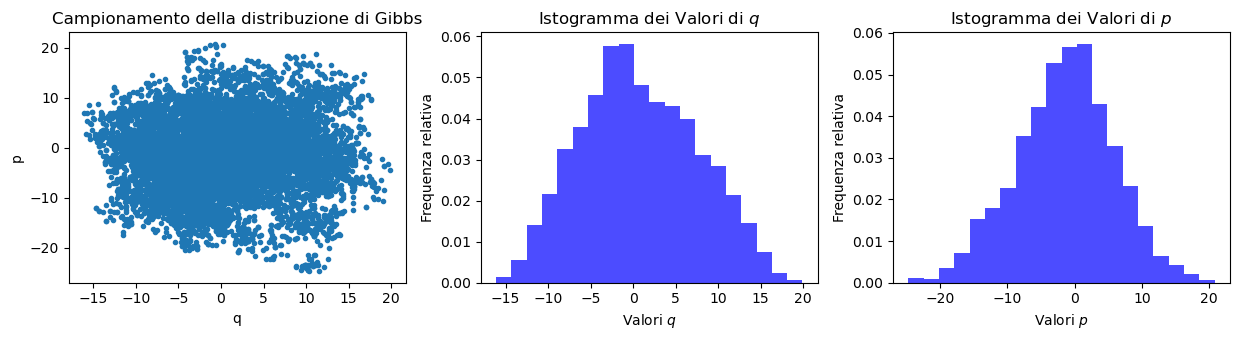

In [11]:
# Crea l'istogramma
plt.figure(figsize=(12.5,3.5))

plt.subplot(1, 3, 1)
# Visualizzazione dei risultati
plt.scatter(sampled_q, sampled_p, marker='.')
plt.xlabel('q')
plt.ylabel('p')
plt.title('Campionamento della distribuzione di Gibbs')

plt.subplot(1, 3, 2)
plt.hist(sampled_q, bins=20, density=True, alpha=0.7, color='blue')  # `bins` definisce il numero di bin nell'istogramma
# Aggiungi etichette e titolo
plt.xlabel('Valori $q$')
plt.ylabel('Frequenza relativa')
plt.title('Istogramma dei Valori di $q$')

plt.subplot(1, 3, 3)
plt.hist(sampled_p, bins=20, density=True, alpha=0.7, color='blue')  # `bins` definisce il numero di bin nell'istogramma
# Aggiungi etichette e titolo
plt.xlabel('Valori $p$')
plt.ylabel('Frequenza relativa')
plt.title('Istogramma dei Valori di $p$')

# Mostra il plot
plt.tight_layout()
plt.show()

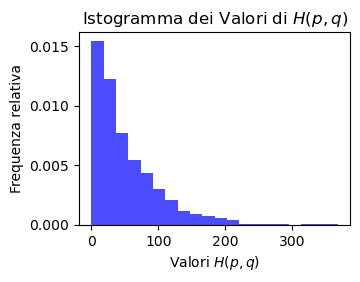

In [12]:
kinetic = (sampled_p*sampled_p)/(2*m)
# potential = (m*omega*omega/2)*(sampled_q*sampled_q)
potential = (m*omega*omega/2)*(sampled_q*sampled_q) + (r/4)*(sampled_q*sampled_q)*(sampled_q*sampled_q)
energy = kinetic + potential

# Crea l'istogramma
plt.figure(figsize=(3.5,2.5))
plt.hist(energy, bins=20, density=True, alpha=0.7, color='blue')  # `bins` definisce il numero di bin nell'istogramma

# Aggiungi etichette e titolo
plt.xlabel('Valori $H(p,q)$')
plt.ylabel('Frequenza relativa')
plt.title('Istogramma dei Valori di $H(p,q)$')

# Mostra il plot
plt.show()

In [74]:
# coefficienti yoshida
denominatore = 2-2**(1/3)

w_0 = -(2**(1/3))/denominatore
w_1 = 1/denominatore

c_1 = w_1/2
c_2 = (w_0 + w_1)/2
c_3 = c_2
c_4 = c_1

d_1 = w_1
d_2 = w_0
d_3 = w_1

In [75]:
def yoshida_coefficients():
    c1 = 0.7845136104775609
    c2 = 0.2355732133593580
    c3 = -1.1776799841788718
    c4 = 1.3151863206839117
    c5 = -1.1776799841788718
    c6 = 0.2355732133593580
    c7 = 0.7845136104775609
    
    return c1, c2, c3, c4, c5, c6, c7

In [91]:
# parametri simulazione
h = 0.001 # timestep
N = 50000 # numero passi

In [92]:
def forza(q):
    return -m*(omega**2)*q-r*q**3

def momento(p):
    return p/m

def yoshida_4(q, p):

    q_temp_1 = q + c_1*momento(p)*h
    p_temp_1 = p + d_1*forza(q_temp_1)*h

    q_temp_2 = q_temp_1 + c_2*momento(p_temp_1)*h
    p_temp_2 = p_temp_1 + d_2*forza(q_temp_2)*h

    q_temp_3 = q_temp_2 + c_3*momento(p_temp_2)*h
    p_temp_3 = p_temp_2 + d_3*forza(q_temp_3)*h

    q_evoluto = q_temp_3 + c_4*momento(p_temp_3)*h
    p_evoluto = p_temp_3

    return q_evoluto, p_evoluto

def yoshida_8(q, p):
    c1, c2, c3, c4, c5, c6, c7 = yoshida_coefficients()
    
    q_new = q + c1 * h * momento(p)
    p_new = p - c1 * h * forza(q_new)
    
    q_new = q_new + c2 * h * momento(p_new)
    p_new = p_new - c2 * h * forza(q_new)
    
    q_new = q_new + c3 * h * momento(p_new)
    p_new = p_new - c3 * h * forza(q_new)
    
    q_new = q_new + c4 * h * momento(p_new)
    p_new = p_new - c4 * h * forza(q_new)
    
    q_new = q_new + c5 * h * momento(p_new)
    p_new = p_new - c5 * h * forza(q_new)
    
    q_new = q_new + c6 * h * momento(p_new)
    p_new = p_new - c6 * h * forza(q_new)
    q_new = q_new + c7 * h * momento(p_new)
    
    return q_new, p_new

In [93]:
q_ensemble = np.zeros(N)
p_ensemble = np.zeros(N)

In [94]:
num_samples/10

1000.0

In [95]:
for realizzazione in range(0, int(num_samples/10)):
    
    q_evoluzione = np.zeros(N)
    p_evoluzione = np.zeros(N)

    q_0 = sampled_q[realizzazione]
    p_0 = sampled_p[realizzazione]

    q_evoluzione[0] = q_0
    p_evoluzione[0] = p_0
    
    for i in range(0, N-1):
        q_evoluzione[i+1], p_evoluzione[i+1] = yoshida_8(q_evoluzione[i], p_evoluzione[i])
        
    q_ensemble += q_evoluzione
    p_ensemble += p_evoluzione

In [96]:
q_ensemble /= int(num_samples/10)
p_ensemble /= int(num_samples/10)

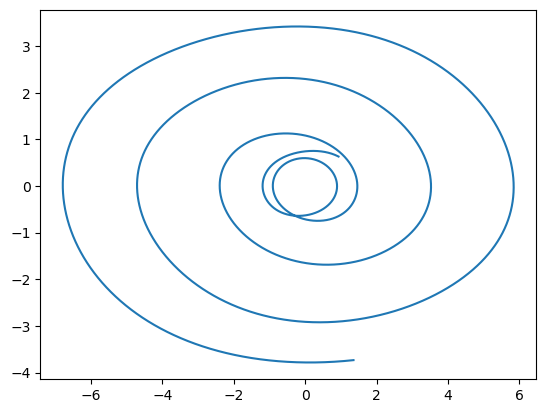

In [97]:
plt.plot(q_ensemble, p_ensemble)

Anche yoshida 8 non funziona. Ma ho i coefficienti e l'implementazione. Tradurrò tutto in FORTRAN.

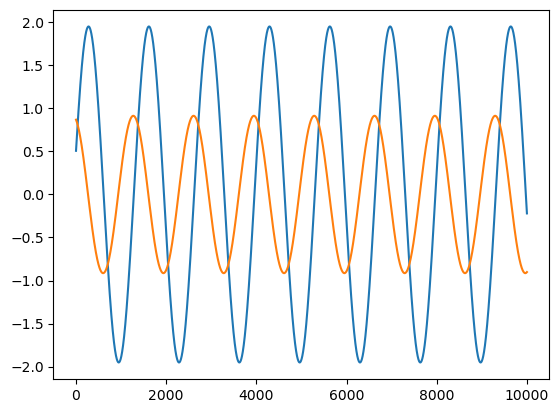